<a href="https://colab.research.google.com/github/fnAdil/ip/blob/main/cats-vs-dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Harici kütüphaneleri kur

In [1]:
!pip install kaggle
!pip install tensorflow





Kütüphaneleri yükle

In [7]:
from google.colab import files
import zipfile
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator,load_img
#from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

Saving kaggle.json to kaggle.json


Kaggle bağlantısı kur

In [8]:
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Klasör oluşturma

In [5]:
os.mkdir('cats-vs-dogs')
os.chdir("cats-vs-dogs")

Kaggle üzerinden veri indirme

In [9]:
!kaggle competitions download -c dogs-vs-cats

 99% 538M/543M [00:02<00:00, 216MB/s]
100% 543M/543M [00:02<00:00, 206MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 86.4MB/s]
 98% 266M/271M [00:02<00:00, 102MB/s] 
100% 271M/271M [00:02<00:00, 96.3MB/s]


İndirilen dosyaları görüntüle

In [10]:
!ls

kaggle.json  sampleSubmission.csv  test1.zip  train.zip


Zip dosyalarını çıkar ve sil

In [11]:
!unzip -q test1.zip
!unzip -q train.zip
!rm test1.zip
!rm train.zip

Resim boyutlarını ayarla

In [12]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

Train verisetini oluştur

In [13]:
filenames=os.listdir("./train")

categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)

df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

Test verisetini oluştur

In [14]:
test_files=os.listdir("./test1")
test_df=pd.DataFrame({
    'filename':test_files,
})

nb_samples = test_df.shape[0]

Modeli ayarla

In [15]:


model=Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

Model özetini görüntüle

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

Learning Rate ayarla

In [17]:

earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

Train verisetindeki kategorileri adlandır

In [18]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,
  random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

Train, validation ve test verisetlerini hazırla

In [19]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "./train/",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./train/", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)

test_generator = train_datagen.flow_from_dataframe(test_df,
                                                 "./test1/",x_col='filename',y_col=None,
                                                 target_size=Image_Size,
                                                 class_mode=None,
                                                 batch_size=batch_size)


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


Eğitime başla

In [20]:
epochs=10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1333/1333 [==============================] - 196s 111ms/step - loss: 0.9443 - accuracy: 0.5877 - val_loss: 0.5601 - val_accuracy: 0.7095


Modeli kaydet

In [21]:
model.save("model1_catsVSdogs_10epoch.h5")

Test et

In [24]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Test verisetindeki kategorileri yeniden adlandır

In [27]:
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'dog': 'dog', 'cat': 'cat' })

Test verilerini görüntüle

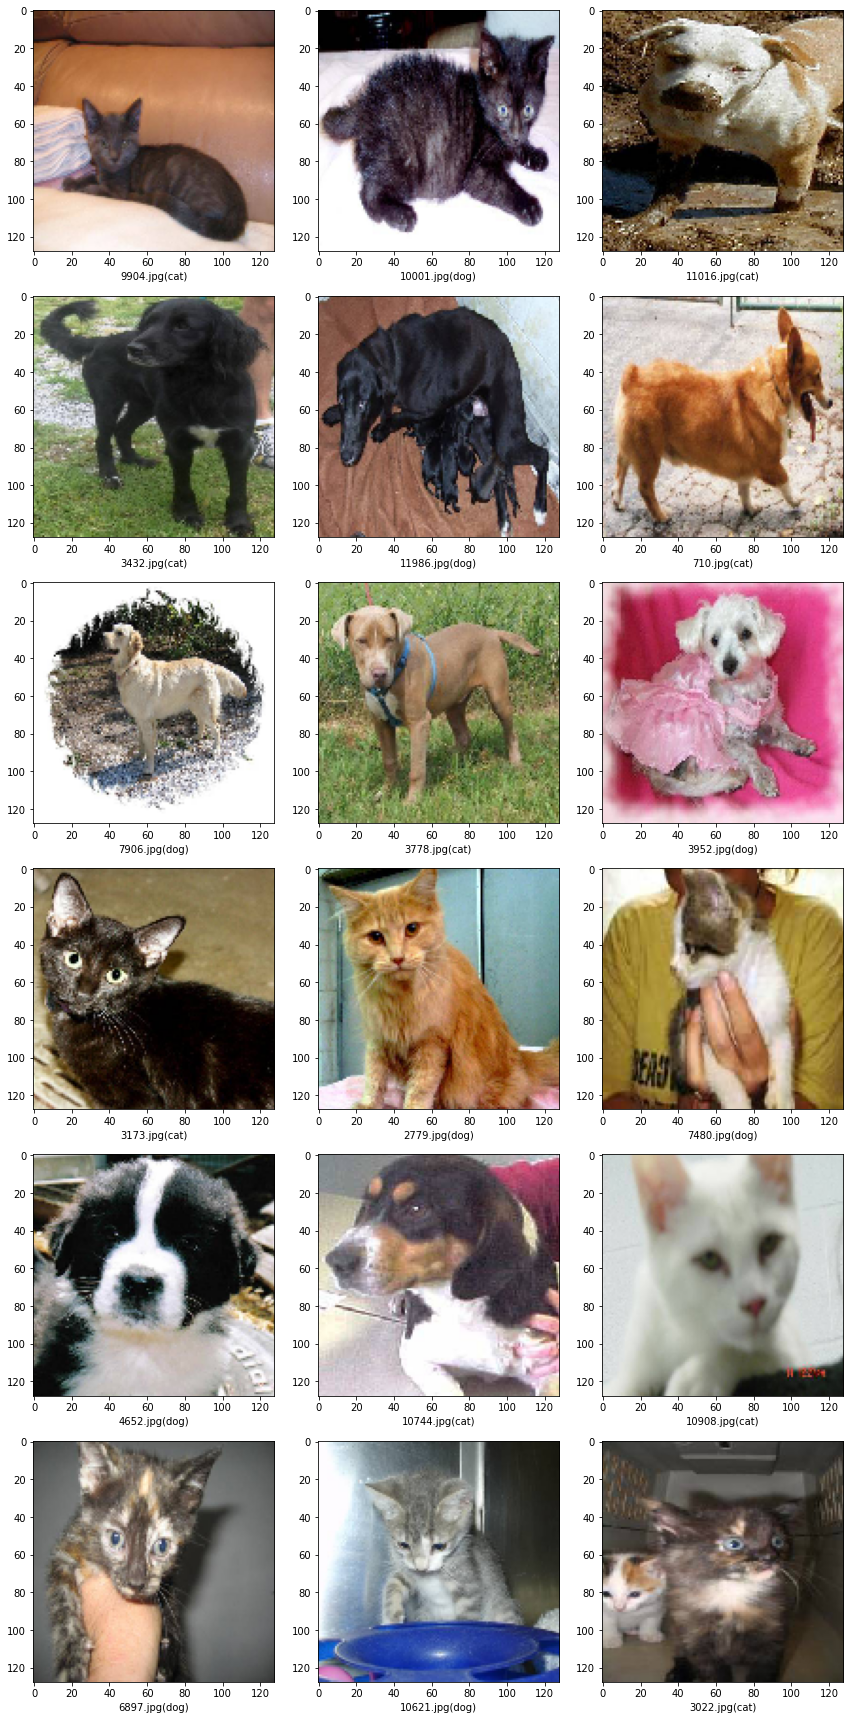

In [28]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./test1/"+filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()